# Fine tune Bleurt

In [3]:
%load_ext autoreload
%autoreload 2
    
import sys
sys.path.append("../")

In [4]:
from typing import List
import numpy as np
import pandas as pd
import warnings
import logging
import os
import gc
import shutil
import json
import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from datasets import Dataset,load_dataset, load_from_disk
from transformers import TrainingArguments, Trainer
from datasets import load_metric, disable_progress_bar
from sklearn.metrics import mean_squared_error
import torch
from sklearn.model_selection import KFold, GroupKFold
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import sent_tokenize
from collections import Counter
import spacy
import re
from autocorrect import Speller
from spellchecker import SpellChecker
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()


warnings.simplefilter("ignore")
logging.disable(logging.ERROR)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
disable_progress_bar()
tqdm.pandas()


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/pedro/py310/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/pedro/py310/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/home/pedro/py310/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('local/deepbox'), PosixPath('@/tmp/.ICE-unix/4917,unix/deepbox')}
  warn(msg)
/home/pedro/py310/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/etc/xdg/xdg-plasma')}
  warn(msg)
/home/pedro/py310/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/org/freedesktop/DisplayManager/Session1')}
  warn(msg)
/home/pedro/py310/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/share/gconf/plasma.mandatory.path')}
  warn(msg

In [5]:
#DATA_DIR = "/kaggle/input/commonlit-evaluate-student-summaries/"
DATA_DIR = "../input/commonlit-evaluate-student-summaries/"

prompts_train = pd.read_csv(DATA_DIR + "prompts_train.csv")
prompts_test = pd.read_csv(DATA_DIR + "prompts_test.csv")
summaries_train = pd.read_csv(DATA_DIR + "summaries_train.csv")
summaries_test = pd.read_csv(DATA_DIR + "summaries_test.csv")
sample_submission = pd.read_csv(DATA_DIR + "sample_submission.csv")
prompts_train_ref = pd.read_csv("../input/prompt_ref_summaries.csv")

prompts_train = prompts_train.merge(prompts_train_ref, on="prompt_id", how="left")

In [6]:
train = pd.read_parquet("tmp_train_preprocessed.parquet")

In [10]:
tokenizer = AutoTokenizer.from_pretrained("Elron/bleurt-base-512")
#model = AutoModelForSequenceClassification.from_pretrained("Elron/bleurt-base-512")
#model.eval()
#_ = model.to("cuda")

In [11]:
prompts_train["n_tokens"] = prompts_train.prompt_text.apply(lambda x: len(tokenizer(x)["input_ids"]))

In [12]:
prompts_train

,prompt_id,prompt_question,prompt_title,prompt_text,_llama2_summ,n_tokens
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,"Aristotle, in Chapter 13 of his ""Poetics,"" out...",767
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,The ancient Egyptian system of government was ...,659
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,"The Third Wave experiment, conducted by histor...",673
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...","The factory in ""The Jungle"" used various metho...",1175


In [14]:
prompts_train_ref["n_tokens"] = prompts_train_ref._llama2_summ.apply(lambda x: len(tokenizer(x)["input_ids"]))

In [17]:
prompts_train.prompt_question.values

array(['Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.',
       'In complete sentences, summarize the structure of the ancient Egyptian system of government. How were different social classes involved in this government? Cite evidence from the text.',
       'Summarize how the Third Wave developed over such a short period of time and why the experiment was ended.',
       'Summarize the various ways the factory would use or cover up spoiled meat. Cite evidence in your answer.'],
      dtype=object)

In [14]:
s0 = """Aristotle outlines three essential elements of an ideal tragedy in Chapter 13 of his "Poetics":

    Complex Plot: Aristotle asserts that a perfect tragedy should have a complex plot, not a simple one.

    Pity and Fear: Tragedy should imitate actions that evoke both pity and fear. The audience should feel sympathy for the characters and fear for their outcomes.

    Character Between Extremes: The protagonist should be a character who is not exceptionally virtuous nor utterly evil but experiences a downfall due to some error or frailty. This character should be renowned and prosperous initially.

Aristotle emphasizes that the change in fortune should move from good to bad, not vice versa. Tragedies should focus on characters like Oedipus or Thyestes. He also argues against double plots with opposite catastrophes, asserting that true tragic pleasure does not come from such endings, which are more suited to comedy.

In summary, Aristotle's ideal tragedy involves a complex plot with a character of intermediate moral standing, leading to a change from good to bad fortune, while evoking pity and fear in the audience."""

s1 = """The ancient Egyptian government had a hierarchical structure resembling a pyramid. At the top were the gods and pharaohs, considered divine rulers with absolute power. Pharaohs managed various responsibilities, including protection, taxation, and law enforcement. A vizier assisted the pharaoh, and scribes maintained records.

Below the pharaoh were nobles and priests, responsible for government posts and religious duties. Soldiers served in wars and supervised laborers during peace. Skilled workers and merchants constituted the middle class, creating and selling goods. Slaves and farmers, who paid substantial taxes, formed the lowest social stratum. While social mobility was rare, some could rise through education and employment opportunities, making bureaucracy a lucrative path."""

s2 = """The Third Wave experiment, conducted in 1967 at Cubberley High School by history teacher Ron Jones, aimed to demonstrate how people follow the crowd even in disturbing situations. Jones started a movement called "The Third Wave" advocating against democracy and emphasizing community over the individual. Initially, the experiment focused on classroom discipline, and it quickly led to improved efficiency and student motivation.

As the week progressed, the movement expanded rapidly, with students from the school joining in. By day four, Jones felt it was getting out of control due to the extreme discipline and loyalty it had instilled in the participants. To end the experiment, he falsely announced a nationwide movement and promised a televised announcement by a presidential candidate. However, when the week concluded, Jones revealed the experiment's true purpose: to show how easily people can create a sense of superiority and justify harmful actions in the name of a cause, highlighting the dangers of conformity."""


s3 = """The factory in "The Jungle" would use or cover up spoiled meat by canning it, turning it into sausage, rubbing sour meat with soda to remove the smell and selling it on free-lunch counters, performing chemical treatments to alter the color, flavor, and odor of spoiled meat, using an apparatus to pump pickle into hams that had gone bad, inserting a white-hot iron into spoiled hams to salvage them, creating various types of hams from leftover pork parts, recycling old and moldy sausage, allowing meat to come into contact with dirt, rats, and dung, using poisoned bread to kill rats that ended up in the sausage, washing hands in water meant for sausage, mixing scraps and waste with fresh meat, and preserving sausage with borax and gelatin while charging extra for some as "special"."""



In [15]:
refp = pd.DataFrame(zip(["39c16e", "3b9047", "814d6b", "ebad26"],[s0,s1,s2,s3]), columns=["prompt_id","ref_summary"])

In [16]:
refp["n_tokens"] = refp.ref_summary.apply(lambda x: len(tokenizer(x)["input_ids"]))

In [12]:
refp

,prompt_id,ref_summary,n_tokens
0,39c16e,Aristotle outlines three essential elements of...,219
1,3b9047,The ancient Egyptian government had a hierarch...,137
2,814d6b,"The Third Wave experiment, conducted in 1967 a...",187
3,ebad26,"The factory in ""The Jungle"" would use or cover...",172


In [70]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [39]:
summaries_train["n_tokens"] = summaries_train.text.apply(lambda x: len(tokenizer(x)["input_ids"]))

In [42]:
def eval_bleurt(data, ref_col, cand_col, model, tokenizer, batchsize=200):
    n_splits = len(data)//batchsize 
    allscores = []
    with torch.no_grad():
        for batch in tqdm(np.array_split(data[[ref_col, cand_col]].values, n_splits)):
            inputs = tokenizer(batch[:,0].tolist(), batch[:,1].tolist(), return_tensors='pt', padding=True, truncation=True)
            inputs = {k:v.to("cuda") for k,v in inputs.items()}
            scores = model(**inputs)[0].squeeze().detach().cpu().numpy()
            allscores += scores.tolist()
    return allscores

In [17]:
train = train.merge(refp, on="prompt_id", how="left")

In [63]:
train["bleurt"] = eval_bleurt(train, "ref_summary", "text", model, tokenizer, batchsize=200)
train["bleurt_ft"] = eval_bleurt(train, "ref_summary", "fixed_summary_text", model, tokenizer, batchsize=200)

100%|█████████████████████████████████████████████████████████████████████████| 35/35 [00:52<00:00,  1.50s/it]


In [66]:
for idx, pid in enumerate(tr.prompt_id.unique()):
    corr = train[train.prompt_id==pid][["content", "bleurt_ft"]].corr().values[0][1]
    print(pid, corr)

814d6b 0.6968817970522873
ebad26 0.6190653255710167
3b9047 0.5609640986899392
39c16e 0.7061628320551014


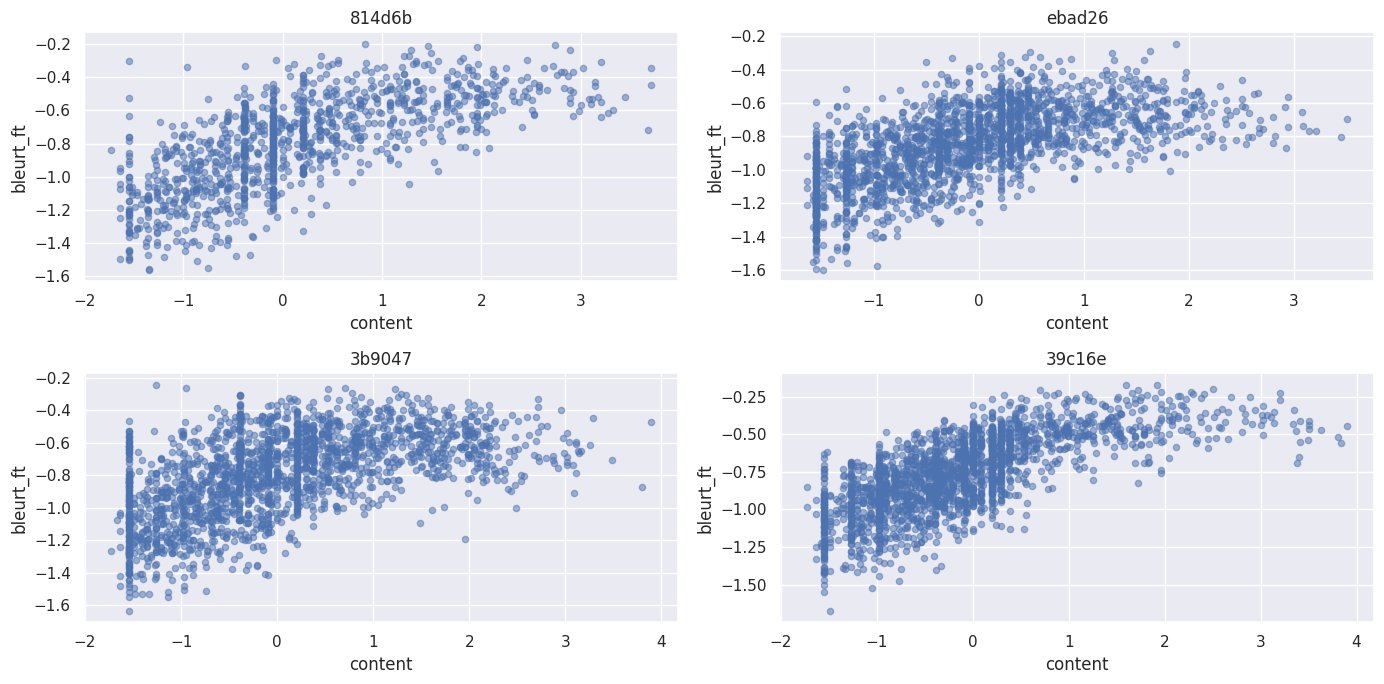

In [67]:
_, ax = plt.subplots(2,2, figsize=(14,7))
ax = ax.flatten()
for idx, pid in enumerate(tr.prompt_id.unique()):
    train[train.prompt_id==pid].plot.scatter(x="content", y="bleurt_ft", alpha=0.5, ax=ax[idx])
    ax[idx].set_title(pid)
plt.tight_layout();

# Folds

In [7]:
gkf = GroupKFold(n_splits=4)

for i, (_, val_index) in enumerate(gkf.split(train, groups=train["prompt_id"])):
    train.loc[val_index, "fold"] = i

# Train

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import DataCollatorWithPadding

class CustomDataset(Dataset):
    def __init__(self, ref_texts, texts, targets, tokenizer, max_length):
        self.ref_texts = ref_texts
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.ref_texts)

    def __getitem__(self, idx):
        ref_text = self.ref_texts[idx]
        text = self.texts[idx]
        target = self.targets[idx]
        encoding = tokenizer(ref_text, text, return_tensors='pt', padding=True, truncation=True)
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "token_type_ids": encoding["token_type_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "targets": torch.tensor(target, dtype=torch.float),
        }



In [9]:
tokenizer = AutoTokenizer.from_pretrained("Elron/bleurt-base-512")


In [10]:
def train_loop(model, train_dataloader, val_dataloader, cfg):

    # Define optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=cfg.learning_rate)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * cfg.num_epochs)
    
    # Define loss function
    loss_fn = nn.MSELoss()
    
    # Training loop
    for epoch in range(cfg.num_epochs):
        model.train()
        total_loss = 0
    
        for batch in train_dataloader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            token_type_ids = batch["token_type_ids"].to("cuda")
            labels = batch["targets"].to("cuda")
            
            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
    
        average_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{cfg.num_epochs}, Loss: {average_loss:.4f}")
    
        # Validation loop
        model.eval()
        val_loss = 0
        correct_predictions = 0
        total_samples = 0
    
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch["input_ids"].to("cuda")
                attention_mask = batch["attention_mask"].to("cuda")
                token_type_ids = batch["token_type_ids"].to("cuda")
                labels = batch["targets"].to("cuda")
                
                outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
                loss = outputs.loss
                
                val_loss += loss.item()
    
                #predictions = outputs.logits.view(-1)
                
    
        average_valid_loss = val_loss / len(val_dataloader)
        print(f"Epoch {epoch+1}/{cfg.num_epochs}, Validation Loss: {average_valid_loss:.4f}")

    return model
        

def predict(model, val_dataloader, cfg):
    output = []
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            token_type_ids = batch["token_type_ids"].to("cuda")
            labels = batch["targets"].to("cuda")
            
            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
            logits = outputs.logits
            
            output += outputs.logits.view(-1).detach().cpu().numpy().tolist()
            
    return output

In [11]:
# Define hyperparameters
class cfg:
    batch_size = 16
    learning_rate = 2e-5
    num_epochs = 3

In [32]:
for fold in range(1,4):
    tr = train[train.fold.ne(fold)].copy()
    val = train[train.fold.eq(fold)].copy()
    
    collate_fn = DataCollatorWithPadding(tokenizer)
    
    # Create data loaders
    train_dataset = CustomDataset(tr.ref_summary.values, tr.text.values, tr.content.values, tokenizer, max_length=512)
    train_dataloader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, collate_fn=collate_fn)
    
    val_dataset = CustomDataset(val.ref_summary.values, val.text.values, val.content.values, tokenizer, max_length=512)
    val_dataloader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn)

    model = AutoModelForSequenceClassification.from_pretrained("Elron/bleurt-base-512")
    model.train()
    _ = model.to("cuda")

    model = train_loop(model, train_dataloader, val_dataloader, cfg)
    model.save_pretrained(f"bleurt_fold_{fold}")

Epoch 1/3, Loss: 0.2899
Epoch 1/3, Validation Loss: 0.2785
Epoch 2/3, Loss: 0.1972
Epoch 2/3, Validation Loss: 0.3596
Epoch 3/3, Loss: 0.1532
Epoch 3/3, Validation Loss: 0.4091
Epoch 1/3, Loss: 0.3011
Epoch 1/3, Validation Loss: 0.4204
Epoch 2/3, Loss: 0.2155
Epoch 2/3, Validation Loss: 0.2329
Epoch 3/3, Loss: 0.1673
Epoch 3/3, Validation Loss: 0.2141
Epoch 1/3, Loss: 0.2847
Epoch 1/3, Validation Loss: 0.3811
Epoch 2/3, Loss: 0.1866
Epoch 2/3, Validation Loss: 0.3276
Epoch 3/3, Loss: 0.1450
Epoch 3/3, Validation Loss: 0.3186


In [20]:
# Make prediction dataset
preds = []
for fold in range(4):
    val = train[train.fold.eq(fold)].copy()
    
    collate_fn = DataCollatorWithPadding(tokenizer)
   
    val_dataset = CustomDataset(val.ref_summary.values, val.text.values, val.content.values, tokenizer, max_length=512)
    val_dataloader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn)

    model = AutoModelForSequenceClassification.from_pretrained(f"bleurt_fold_{fold}")
    model.eval()
    _ = model.to("cuda")

    val["pred"] = predict(model, val_dataloader, cfg)
    preds.append(val[["student_id", "pred"]])

preds = pd.concat(preds)

In [22]:
preds.shape, train.shape

((7165, 2), (7165, 36))

In [23]:
train = train.merge(preds, on="student_id", how="left")

In [26]:
np.sqrt(mean_squared_error(train.content, train.pred))

0.47909144879778764

In [27]:
train["student_id"].nunique(), train.shape[0]

(7165, 7165)

In [28]:
train = train.rename(columns={"pred": "content_bleurt_pred"})
train[["student_id", "content_bleurt_pred"]].to_parquet("content_bleurt_pred.parquet", index=False)

In [83]:
#tokenizer(["hello world", "second"], ["hi mom", "try"], return_tensors='pt', padding=True, truncation=True)

In [ ]:
# cv
rmses = []

for target in targets:
    models = model_dict[target]

    preds = []
    trues = []
    
    for fold, model in enumerate(models):
        X_eval_cv = train[train["fold"] == fold].drop(columns=drop_columns)
        y_eval_cv = train[train["fold"] == fold][target]

        pred = model.predict(X_eval_cv)

        trues.extend(y_eval_cv)
        preds.extend(pred)
        
    rmse = np.sqrt(mean_squared_error(trues, preds))
    print(f"{target}_rmse : {rmse}")
    rmses = rmses + [rmse]

print(f"mcrmse : {sum(rmses) / len(rmses)}")